In [1]:
import os
import cv2
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_zip_local = '/content/drive/My Drive/kvasir-dataset-v2.zip'
zip_ref = zipfile.ZipFile(dataset_zip_local, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
dataset_dir='/tmp/kvasir-dataset-v2'
category_lst=['normal-z-line',
              'normal-pylorus',
              'normal-cecum',
              'esophagitis',
              'polyps',
              'ulcerative-colitis',
              'dyed-lifted-polyps',
              'dyed-resection-margins']

In [4]:
def process_dataset(category_lst):
  X= []
  Y = []
  for category in category_lst:
    category_path = os.path.join(dataset_dir,category)
    for image in os.listdir(category_path):
      try:
        image_path = os.path.join(category_path,image)
        image_arr = cv2.imread(image_path)
        resized_image_arr = cv2.resize(image_arr,(224,224))
        X.append(resized_image_arr)
        Y.append(category_lst.index(category))
      except Exception as e:
        print(e)
        pass
  return X,Y

In [5]:
X,Y = process_dataset(category_lst)
X = np.array(X, dtype=np.float32)
X /= 255.0
print(X.shape)

(8000, 224, 224, 3)


In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

Y_train = tf.keras.utils.to_categorical(Y_train, 8)
Y_test = tf.keras.utils.to_categorical(Y_test, 8)

In [7]:
pre_trained_model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

In [8]:
for layer in pre_trained_model.layers[len(pre_trained_model.layers)-10:]:
    layer.trainable = True

X = pre_trained_model.output
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(1024, activation="relu")(X)
X = tf.keras.layers.Dense(512, activation="relu")(X)
X = tf.keras.layers.Dropout(0.7)(X)


outputs = tf.keras.layers.Dense(8, activation="softmax")(X)   
model = tf.keras.models.Model(pre_trained_model.input,outputs)

model.compile(loss = "categorical_crossentropy",optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),metrics=["accuracy"])

In [9]:
hist=model.fit(X_train,Y_train,
                  batch_size=32,
                  epochs=50,
                  verbose=1,
                  validation_data=(X_test, Y_test))

Epoch 1/50
200/200 [==============================] - 96s 277ms/step - loss: 2.0841 - accuracy: 0.2564 - val_loss: 0.7856 - val_accuracy: 0.7381
Epoch 2/50
200/200 [==============================] - 55s 277ms/step - loss: 0.8647 - accuracy: 0.6748 - val_loss: 0.4752 - val_accuracy: 0.8313
Epoch 3/50
200/200 [==============================] - 55s 276ms/step - loss: 0.5578 - accuracy: 0.7827 - val_loss: 0.3881 - val_accuracy: 0.8650
Epoch 4/50
200/200 [==============================] - 55s 275ms/step - loss: 0.4151 - accuracy: 0.8440 - val_loss: 0.3717 - val_accuracy: 0.8600
Epoch 5/50
200/200 [==============================] - 55s 276ms/step - loss: 0.3160 - accuracy: 0.8794 - val_loss: 0.3554 - val_accuracy: 0.8569
Epoch 6/50
200/200 [==============================] - 55s 276ms/step - loss: 0.2627 - accuracy: 0.8978 - val_loss: 0.3350 - val_accuracy: 0.8788
Epoch 7/50
200/200 [==============================] - 55s 276ms/step - loss: 0.2274 - accuracy: 0.9157 - val_loss: 0.3268 - val_ac

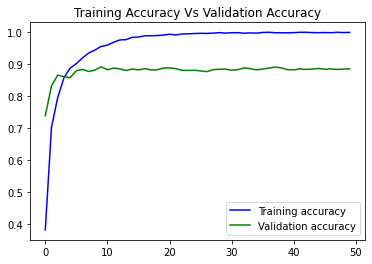

<Figure size 432x288 with 0 Axes>

In [10]:
model.save('inception-v3-weights.h5')

epochs = range(len(hist.history['accuracy']))

plt.plot(epochs, hist.history['accuracy'] , 'b', label='Training accuracy')
plt.plot(epochs, hist.history['val_accuracy'] , 'g', label='Validation accuracy')

plt.title('Training Accuracy Vs Validation Accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()